# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:green;>Completed</span></b></p>

##### LOCATE IMAGE FILE NAMES
Cat : 0 | Dog : 1

In [4]:
import os
import pandas as pd
import numpy as np

data_dir = '../../../data/'
class_list = os.listdir(data_dir)  # get classes based on folder names

filename_list = []

# make a list of the images' file names, cats and dogs
for _class in class_list:
    filename_list_class = os.listdir(data_dir + _class)
    filename_list_class = [(_class + '/' + fname) for fname in filename_list_class if fname.endswith('.jpg')]
    filename_list += filename_list_class

# shuffle the dataset
np.random.seed(45)
np.random.shuffle(filename_list)

# adjust the dataset size
filename_list = filename_list[:1500]

print('Total number of files : ', len(filename_list))
filename_list[:10]

Total number of files :  1500


['Cat/6391.jpg',
 'Cat/1734.jpg',
 'Cat/10324.jpg',
 'Cat/3560.jpg',
 'Cat/3121.jpg',
 'Cat/5482.jpg',
 'Cat/1708.jpg',
 'Dog/7152.jpg',
 'Cat/11101.jpg',
 'Dog/10136.jpg']

## ------- DATA PREPROCESSING -------

##### PREPARE TO STORE DATASET CHARACTERISTICS

In [5]:
# this will store the information from every image
X = []  # feature
y = []  # labels

N_CHANNELS = 3     # three colors: RGB
IMG_SIZE = 227     # this value indicates the image will be resized to ??x??

n_images = len(filename_list)

X = np.ndarray(shape=(n_images, IMG_SIZE, IMG_SIZE, N_CHANNELS),
               dtype=np.float32)

##### EXTRACT IMAGE INFORMATION
This block will read every image to resize them and store their labels

  0%|          | 0/1500 [00:00<?, ?it/s]

3 invalid file(s) were found

Printing the resulting dataset :

LABEL : Cat


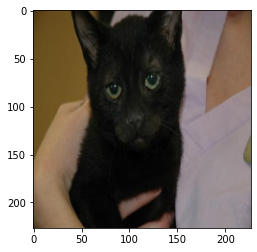

array([[[ 18.,  51.,  77.],
        [ 20.,  53.,  79.],
        [ 21.,  54.,  80.],
        ...,
        [ 46.,  72., 102.],
        [ 51.,  74., 100.],
        [ 51.,  75.,  99.]],

       [[ 18.,  51.,  77.],
        [ 20.,  53.,  79.],
        [ 22.,  55.,  81.],
        ...,
        [ 47.,  73., 103.],
        [ 50.,  75., 100.],
        [ 50.,  76., 100.]],

       [[ 19.,  52.,  78.],
        [ 20.,  53.,  79.],
        [ 22.,  55.,  81.],
        ...,
        [ 47.,  73., 103.],
        [ 50.,  75., 101.],
        [ 51.,  77., 101.]],

       ...,

       [[ 28.,  52.,  70.],
        [ 31.,  55.,  73.],
        [ 39.,  65.,  82.],
        ...,
        [128., 121., 128.],
        [126., 120., 126.],
        [122., 115., 122.]],

       [[ 27.,  49.,  67.],
        [ 30.,  53.,  71.],
        [ 37.,  61.,  79.],
        ...,
        [128., 121., 128.],
        [125., 118., 125.],
        [121., 114., 121.]],

       [[ 26.,  47.,  65.],
        [ 30.,  52.,  70.],
        [ 33.,  

In [6]:
%matplotlib inline
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import cv2

# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x


# make a list for the name of failed files
fail_dir_list = []

# count the number of valid images that were read
img_counter = 0

for f in tqdm(range(len(filename_list))):
    # read every image file directory
    img_path = data_dir + filename_list[f]
        
    try:
        # Read and resize every image
        img = cv2.imread(img_path, 1)  # 1 : Color
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

        # build the list with feature data [RGB values]
        X[img_counter, :, :, :] = img

        # split image directory name
        fname_split = filename_list[f].split('/')  # =[Cat, 10.jpg] example
        
        # build the list with labels [cats | dogs]
        class_name = fname_split[0]
        y.append(class_name)

        img_counter += 1

    except Exception as e:
        # log names of files with errors
        fail_dir_list.append(img_path)
        pass

# remove empty arrays
X = X[:img_counter]

print('{} invalid file(s) were found\n'.format(len(fail_dir_list)))
print('Printing the resulting dataset :\n')

# plot a sample from the list of images [features]
print('LABEL : ' + y[0])
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB).astype(np.uint8))
plt.show()

print('\nRaw data (first image):')
X[0]

##### TRANSFORM THE TARGET VALUES TO ONE-HOT ENCODING

In [7]:
y = pd.get_dummies(y)
y.head()

,Cat,Dog
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [8]:
from sklearn.model_selection import train_test_split

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=13)

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (1197, 227, 227, 3)
y_train : (1197, 2)

X_test : (300, 227, 227, 3)
y_test : (300, 2)


## ------- MODEL TRAINING -------

##### CHECK USE OF AVAILABLE CPU AND GPU

In [9]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [10]:
from tensorflow.python.client import device_lib
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print('\nAccelerated by GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print('Currently running on CPU....')

print('\n\nList of available devices:')
device_lib.list_local_devices()


Accelerated by GPU Device:/device:GPU:0


List of available devices:


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15886005299538873634
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14398783488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8993032481525261224
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

##### DEFINE NETWORK PARAMETERS

In [11]:
# extract images properties
n_classes = np.shape(y_train)[1]

# count number of samples in each set of data
n_train = np.shape(X_train)[0]
n_test = np.shape(X_test)[0]

# define amount of neurons
n_layer_in = None          # this will depends on the conv layer configurations
n_layer_h1 = 4096          # first   hidden layer
n_layer_h2 = 4096          # second  hidden layer
n_layer_out = n_classes    # 2 neurons in output layer

sigma_init = 0.01   # for randomized initialization
drop_prob = 0.25    # for the dropout layers

##### NETWORK DESIGN
This notebook tries to explain the CNN model using the ALEXNET architecture design

In [12]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://www.researchgate.net/profile/Kai-Heinrich-3/publication/337486420/figure/fig2/AS:829046489370626@1574671494481/Architecture-of-AlexNet-Krizhevsky-et-al-2012.ppm")

##### MODEL ARCHITECTURE

In [20]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation, Dropout
from tensorflow.keras.optimizers import SGD

###############################################
## ------ CONVOLUTIONAL NEURAL NETWORK ------##    
###############################################
    
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

##############################################
## ------ FEED FORWARD NEURAL NETWORK ------##
##############################################

model.add(Flatten())

model.add(Dense(n_layer_h1, input_shape=X_train.shape[1:]))
model.add(Dropout(drop_prob))
model.add(Activation('relu'))

model.add(Dense(n_layer_h2))
model.add(Dropout(drop_prob))
model.add(Activation('relu'))

model.add(Dense(n_classes))
model.add(Activation('softmax'))
#model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 384)      

##### RESULTING NEURAL NETWORK ARCHITECTURE

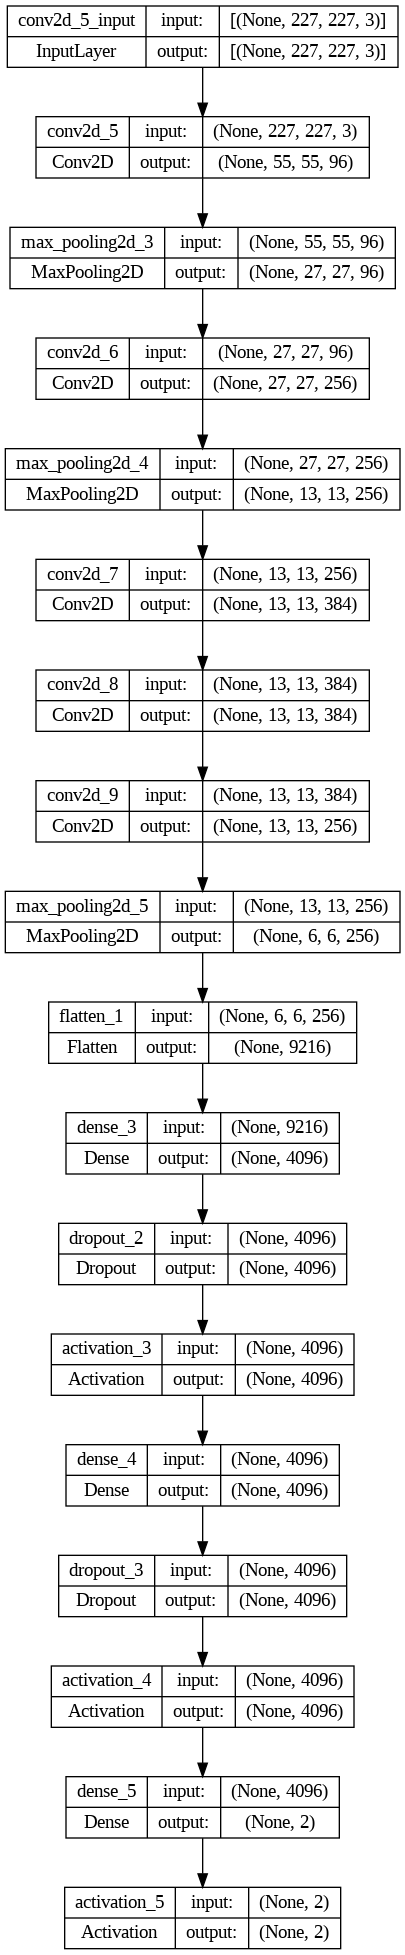

In [21]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "Our_AlexNet.png", show_shapes=True)

##### DEFINE DIRECTORIES FOR RESULTS

In [22]:
import sys
import shutil
from datetime import datetime

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_ckpoint = 'output/tf_checkpoints'
root_logdir = 'output/tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now) 

# try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(root_ckpoint)
except OSError as e:
    print ('Error: %s - %s.' % (e.filename, e.strerror))

Error: output/tf_checkpoints - No such file or directory.


##### MODEL EXECUTION

In [23]:
# define loss function and optimizers
optimizer = tensorflow.keras.optimizers.Adadelta(lr=0.10)
loss = tensorflow.keras.losses.categorical_crossentropy

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# execute the model
history = model.fit(X_train, y_train, epochs=400, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/400
240/240 [==============================] - 8s 25ms/step - loss: 0.6929 - accuracy: 0.4921 - val_loss: 0.6927 - val_accuracy: 0.5733
Epoch 2/400
240/240 [==============================] - 6s 24ms/step - loss: 0.6933 - accuracy: 0.4854 - val_loss: 0.6923 - val_accuracy: 0.6133
Epoch 3/400
240/240 [==============================] - 6s 23ms/step - loss: 0.6925 - accuracy: 0.5305 - val_loss: 0.6919 - val_accuracy: 0.6067
Epoch 4/400
240/240 [==============================] - 6s 25ms/step - loss: 0.6923 - accuracy: 0.5388 - val_loss: 0.6915 - val_accuracy: 0.5833
Epoch 5/400
240/240 [==============================] - 6s 25ms/step - loss: 0.6920 - accuracy: 0.5355 - val_loss: 0.6913 - val_accuracy: 0.6267
Epoch 6/400
240/240 [==============================] - 6s 23ms/step - loss: 0.6916 - accuracy: 0.5464 - val_loss: 0.6910 - val_accuracy: 0.6267
Epoch 7/400
240/240 [==============================] - 6s 25ms/step - loss: 0.6916 - accuracy: 0.5447 - val_loss: 0.6903 - val_accuracy:

##### VISUALIZE THE ACCURACY RESULTS

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

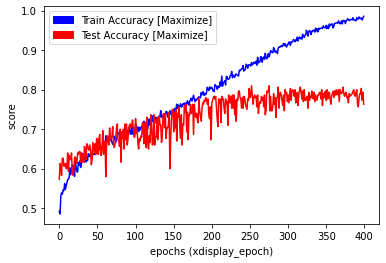

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

#plot the data
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')

plt.xlabel('epochs (x{})'.format('display_epoch'))
plt.ylabel('score');